# Project for the Optimization for Data Science lecture

*Authors* : Alexandre Gramfort, Stéphane Gaiffas

## Objectives of the project

The aim of this project is to implement and use matrix factorization 
techniques to improve a classification problem. Namely, we will use the coefficients 
(also called codes or sparse codes below) as new features, instead of the raw features 
(here pixels from face images). The algorithms will be applied on a labelled face dataset.

## Description of the data

You will use the "Labeled Faces in the Wild" face recognition dataset.
This dataset is a collection of JPEG pictures of famous people collected over the internet,
all details are available on the official website: http://vis-www.cs.umass.edu/lfw/.
The downloading and preprocessing of the dataset is done is the code below.

## Step-by-step objectives 

1. Read and understand classification of the faces using the raw images
- Read and understand classification using features coming out of the SVD
- Code a routine doing (batch) dictionary learning
- Classification of the faces using the sparse code coming out of a dictionary learning as features.
- Compare all solutions in terms of accuracy of classification
- Try to improve the routine for dictionary learning using an online approach

## Notes

You will use **only** simple kNN (k-nearest neighbour) classification for the project.
The focus is on the benefits of using a matrix factorization technique (SVD, NMF, sparse dictionary learning) prior to a classification problem, to obtain better and more expressive features for classification.
In summary, the different methods to compare are the following:


1. kNN on raw features
- kNN on SVD/PCA features
- kNN on batch sparse dictionary learning features
- kNN on batch sparse dictionary learning features with non-negativity constraints
- kNN on online dictinoary learning features

## Evaluation

For evaluation of the project, we will look at what you have been able to implement, but also on the quality of your comments and explanations.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Download and load the face dataset

**NOTE**: this might take some time depending on your connection. 
Don't hesitate to wait and try several times.

In [5]:
from sklearn import decomposition

# fetch_lfw_people is the routine that download the data for you
from sklearn.datasets import fetch_lfw_people

# Download faces data
dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# X contains the 1288 flattened images
X = dataset.data
# X contains the 1288 images of size (50, 37)
images = dataset.images
# y contains the targets: the label to be predicted
y = dataset.target
# target_names contains the name corresponding to the target
target_names = dataset.target_names

## Let's plot a subset of the data

In [7]:
images.shape

(1288L, 50L, 37L)

The dataset contains $1288$ images of size $50 \times 37$ pixels. Let's plot the first ones.

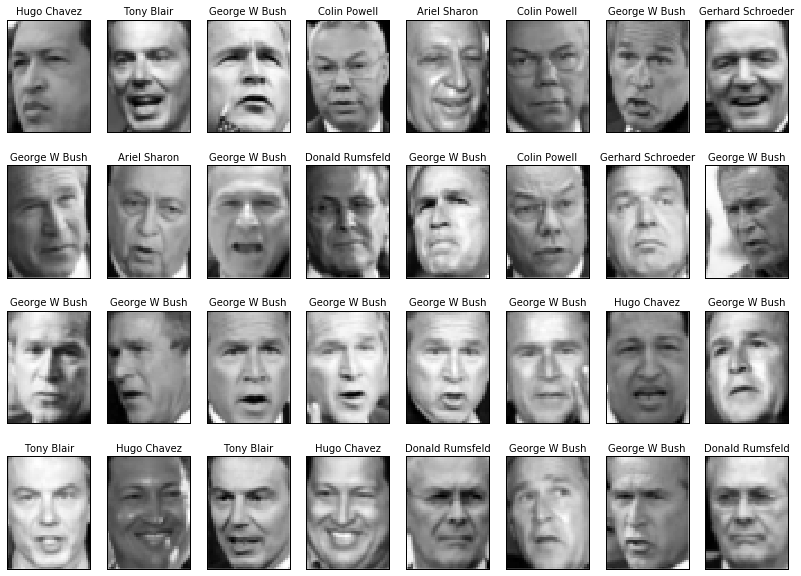

In [8]:
plt.figure(figsize=(14, 10))

n_rows, n_cols = 4, 8
for k in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, k + 1)
    plt.imshow(images[k], cmap=plt.cm.gray, interpolation='none')
    plt.xticks(())
    plt.yticks(())    
    plt.title(target_names[y[k]], size=10)

## Main objective

The aim will be to predict the label (name of the person's face) based on its picture.
To achieve this, we'll use a very simple classifier (kNN), but on features learned from a 
factorization of the $(1288 \times 1850)$ matrix `X` containing all flattened faces.
Once again, `images` contains the faces, while `X` contains the flattened faces.

This means that 

    X[k].reshape(50, 37)

is the same as

    images[k]

for all images `k` between 0 and 1287.

When applying matrix factorization and dictionary learning, it we will work on the flattened version below, contained in `X`, see below.

## Matrix factorization

Let us denote the number of samples $n$ and the number of features $p$ such that, following scikit-learn conventions, we have $X \in \mathbb{R}^{n \times p}$.

We are interested in factorizing the matrix $X^\top$ introducing a matrix $D \in \mathbb{R}^{p \times k}$ that we will call the *dictionary* and a matrix $A \in \mathbb{R}^{k \times n}$ that we will call the *code*. It is called the code as each column $i$ of $A$ contains the coeffecients for the sample $i$. The code is in dimension $k$ which corresponds to the number of columns in $D$. We will say that $k$ is the number of *atoms* in the dictionary.

The matrix $D$ and $A$ should verify that $X^\top \approx DA$

Matrix factorization in an unsupervised problem for which performance is hard to evaluate. In order to have an objective metric for the quality of the code $A$ we will use the code as new features using a k-NN (k=1) classifier.

We will now illustrate this using Singular Value Decomposition (SVD). The different variants of dictionary learning boil down to imposing different constraints on $D$ or $A$.

## Preprocessing : centering of the data

In [9]:
n_samples, n_features = X.shape

# global centering
X_centered = X - X.mean(axis=0)

# local centering
X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

In [12]:
def plot_faces(faces, n_rows=4, n_cols=8, label=True):
    plt.figure(figsize=(14, 10))
    n_rows, n_cols = 4, 8
    face_shape = (50, 37)
    for k, flat_face in enumerate(faces):
        if k >= n_rows * n_cols:
            break
        face = flat_face.reshape(face_shape)
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(face, cmap=plt.cm.gray, interpolation='none')
        plt.xticks(())
        plt.yticks(())
        plt.colorbar()
        if label:
            plt.title(target_names[y[k]], size=10)

The data looks that this now

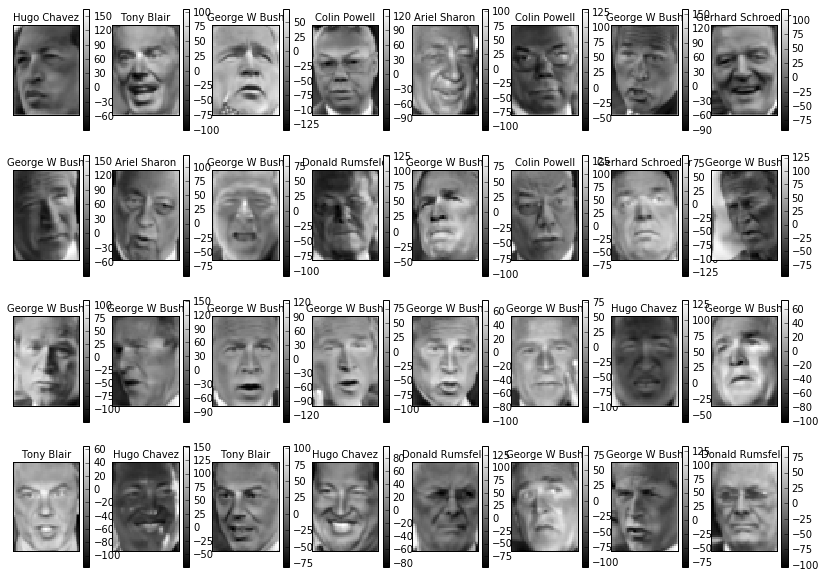

In [42]:
plot_faces(X_centered)

# Classification with kNN using the raw faces

First, we use a simple kNN classifier on the raw features (flattened faces, namely the lines of `X`). All evaluations are done by looking at the cross-validation score

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

# The kNN classifier
clf = KNeighborsClassifier(n_neighbors=1)

# Compute the cross-validation score of kNN on the raw features
scores_raw = cross_val_score(clf, X_centered, y, cv=2)
score_raw = np.mean(scores_raw)

print("Cross-validation score using raw features : %s" % scores_raw)

Cross-validation score using raw features : [ 0.58049536  0.6105919 ]


# Classification with kNN using the SVD features

In [13]:
from sklearn.decomposition import PCA
from scipy import linalg

# Apply SVD with on X_centered and get the D and A matrices
U, S, Vh = linalg.svd(X_centered.T, full_matrices=False)
D = U * S
A = Vh

Let's visualize the atoms

They look ugly... and are something referred to as "eigen faces".

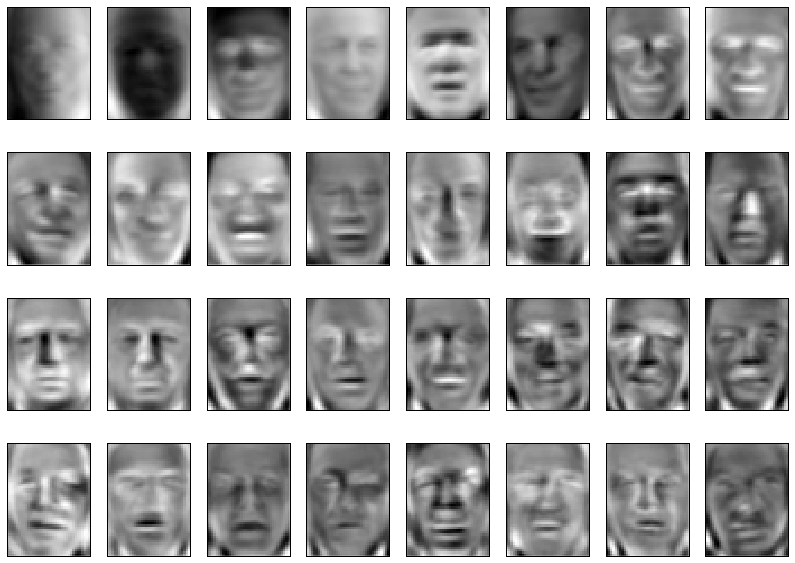

In [14]:
plot_faces(D.T, label=False)

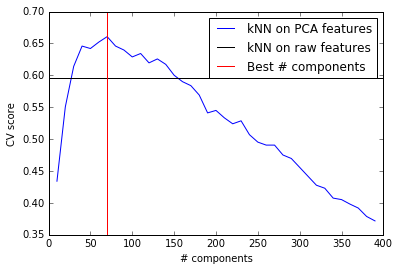

In [15]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
clf = KNeighborsClassifier(n_neighbors=1)

scores_pca = []
n_components_range = np.arange(10, 400, 10)
for n_components in n_components_range:
    # n_components is the rank used in the SVD when fitting the PCA
    X_pca = A[:n_components, :].T
    score_pca = cross_val_score(clf, X_pca, y, cv=2).mean()
    scores_pca.append(score_pca)

plt.plot(n_components_range, scores_pca, label='kNN on PCA features')
plt.axhline(np.mean(score_raw), color='k', label='kNN on raw features')
plt.axvline(n_components_range[np.argmax(scores_pca)], color='r', label='Best # components')
plt.legend(loc='best')
plt.xlabel('# components')
plt.ylabel('CV score')

In summary, the features coming from SVD give a good improvement over the use of the raw features. Yet the atoms obtained with an SVD have no contraints: they don't have positive entries, and the new features don't have any sparsity properties. The idea is change the constraints on $D$ and $A$ during estimation to obtain good features.

# Classification with kNN using dictionary learning

The problem of sparse dictionary learning reads

$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|A\|_1
$$

under the constraints that the norm of each atom $\|D_i\| \le 1, \forall 1 \le i \le k$.
Here $\|A\|_1 = \sum_{i,j} |A_{ij}|$, i.e. it's the sum of the $\ell_1$ norm of each column of A.

This model was for example proposed in:

http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf

# YOUR MISSION :

- Propose and implement a method to estimate $D$ and $A$ by minimization of the sparse dictionary learning cost function. You will notice that the function to minimize is not jointly convex in $D$ and $A$ but that it is convex in $D$ when $A$ is fixed and convex in $A$ when $D$ is fixed. This suggests that you can use an alternated minimization technique.
- Apply the solver you developped above to obtain $D$ and $A$ by solving
$$
\min_{D,A} \frac{1}{2} \|X^\top - DA\|^2 + \lambda \|D\|_1
$$
subject to $\|A_i\| \le 1, \forall 1 \le i \le k$ (here $A_i$ stands for the $i^{th}$ row of $A$.
- As it was done with SVD above, evaluate the quality of the code with k-NN and visualize the atoms. What is the impact of the $\ell_1$ norm penalty on the atoms? You should observe that you will need to find a good $\lambda$.
- Add a non-negativity constraint on $D$ and $A$, i.e. $D_{ij} \geq 0$ and $A_{ij} \geq 0$. Does it improve the performance?
- Implement the online method from Mairal et al. (http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf).

WARNING: Some preprocessing of $X$ such as centering does not make sense if you use non-negativity constraints.

## Question 1,2,3 & 4 : Batch dictionary learning

Shape of $ X^{T} - DA$ is $(p,n)$



Shape of $ A $ is $(k,n)$


Let's rewrite the function to minimize :

$$\frac{1}{2} ||X^{T} - DA||_F^2 + \lambda ||A||_1$$ 

$$=\frac{1}{2} \sum\limits_{i=1}^p \sum\limits_{j=1}^n (X^{T} - DA)_{ij}^2 + \lambda \sum\limits_{i=1}^k \sum\limits_{j=1}^n |A_{ij}|$$

$$=\sum\limits_{j=1}^n ( \frac{1}{2} \sum\limits_{i=1}^p (X^{T} - DA)_{ij}^2 + \lambda \sum\limits_{i=1}^k |A_{ij}| ) $$

$$=\sum\limits_{j=1}^n ( \frac{1}{2} ||(X^{T} - DA)_j||_{2}^2 + \lambda ||A_{j}||_1 ) $$

All the terms in the sum over $j$ or postive, thus, minimizing the sum over $A,D$ is equivalent to minimize each terms independently, i.e., when $A$ is fixed, apply a Lasso column-wise over $D$ taking into account the $\lambda$ penalty, and when D is fixed, apply a least-square over $A$. If we want to perform the the minimization proposed in question 2, the same argument will be valid line-wise. Thus, in all cases, the algorithm is the same, we just have to be careful on the way we apply it.

To do this double minimization, I re-used the ISTA solver developped in the practical sessions.

Note : we could also use the FISTA solver, but I chose the ISTA because the algorithm is slightly simpler.

In the algorithm, I use the notation bellow :
$$
f(D,A) = \frac{1}{2}||X^T - DA||_F^2 
$$
$$
g(Z) = \lambda ||Z||_1 $$

Then, when A is fixed, the gradient of $f$ with respect to D is :

$$\nabla_Df = (DA- X^T)A^T$$

When D is fixed, the gradient of $f$ with respect to A is :

$$\nabla_Af = D^T(DA - X^T)$$

The proximal operator is the one associated to the lasso penalization, as before (applied element-wise) :

$$ prox(Z) = sign(Z)\odot(|Z| - \lambda)_+$$

In [6]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from scipy import linalg
import numpy as np
from numpy.linalg import norm

def prox_lasso(A, l_l1):
    """Proximal operator for the L1 norm / Lasso at x"""
    x_abs = np.abs(A)
    return np.sign(A) * np.maximum(x_abs - l_l1, 0)
def lasso(Z, l_l1):
    """Value of the Lasso penalization at Z"""
    return l_l1 * np.abs(Z).sum()

def f(A, D):
    """Here our f function is just the least-square loss"""
    return 0.5 * norm(X.T - D.dot(A)) ** 2     
def g(Z):
    """here our g function is simply the lasso function"""
    return lasso(Z, l_l1)

def grad_A(A, D):
    return  (D.T).dot(D.dot(A) -X.T)

def grad_D(D, A): 
    return (D.dot(A) -X.T).dot(A.T)

def lipschitz_constant(Z):
    return np.max(np.linalg.eigvalsh(Z.dot(Z.T)))

def error(X,A,D):
    return norm(X.T - D.dot(A)) / norm(X)

def non_negative_threshold(Z):
    neg_coefs = Z<0
    Z[neg_coefs] = 0
    return Z

Then we just re-use the ISTA algorithm, same step size calculations, same $prox$ operator, but with to updates of matrices at each iteration : one for $A$ and one for $D$

In [7]:
def solver(D0, A0, l_l1=0., n_iter=50, method = "sparse code", non_neg = False, verbose = False):
    
    A = A0.copy()
    z = A0.copy()
    D = D0.copy()
    
    # objective and errors history
    objectives = []
    errors = []
    
    if method == "sparse code":
        step1 = 1 / lipschitz_constant(D)
        step2 = 1 / lipschitz_constant(A)
        # Define the prox 
        def prox_g(x, D, t):
            return prox_lasso(x- t*grad_A(x,D) ,t*l_l1)  
        # Define the objective
        def obj(A,D):
            return f(A, D) + g(A)
    
    if method == "sparse dico":
        step1 = 1 / lipschitz_constant(A)  
        step2 = 1 / lipschitz_constant(D)
        #Define the prox
        def prox_g(x, D, t):
            return prox_lasso(x- t*grad_D(x,D) ,t*l_l1) 
        # Define the objective
        def obj(A,D):
            return f(A, D) + g(D)
   
    #Initial objective value
    objectives.append(obj(A,D))
   
    #Initial estimation error
    errors.append(error(X,A,D))
    
    
    print "Lauching ISTA solver..."    
    print ' | '.join([name.center(8) for name in ["it", "obj", "err"]])

    for k in range(n_iter):
        
        if method == "sparse code":
            # Lasso update
            A_new = prox_g(A,D, step1)
            # Gradient Descent update
            D_new = D - step2*grad_D(D, A)
            # Normalize the new dico to meet the normal constraint
            D_new = normalize(D_new, norm="l2", axis = 1)
            # Update the matrices 
            if non_neg == True:
                A = non_negative_threshold(A_new)
                D = non_negative_threshold(D_new)
            else :
                A = A_new
                D = D_new
            # Update of the step size
            step1 = 1 / lipschitz_constant(D)
            step2 = 1 / lipschitz_constant(A)
        
        if method == "sparse dico":
            # Lasso update
            D_new = prox_g(D,A, step1)
            #Projected Gradient Descent with Fista update
            A_new = A - step2*grad_A(A, D)
            # Normalize the new code to meet the normal constraint
            A_new = normalize(A_new, norm = "l2", axis = 1)
            # Update the matrices 
            if non_neg == True:
                A = non_negative_threshold(A_new)
                D = non_negative_threshold(D_new)
            else :
                A = A_new
                D = D_new
            # Update of the step size
            step1 = 1 / lipschitz_constant(A)
            step2 = 1 / lipschitz_constant(D)
        
        
            
        objectives.append(obj(A,D))
        errors.append(error(X,A,D))
        
        if k % 10 == 0 and verbose == True:
            print ' | '.join( [ ("%d" % k).rjust(8), ("%.2e" % obj(A,D)).rjust(8), ("%.2e" % error(X,A,D)).rjust(8)])
    print "...finished"
    return A, objectives, D

Now we can use this solver to solve the problems question 1, 2, 3 and 4.

Note : the problem is non convex in $A,D$. Our solver will not converge to a global minimum. Thus, the algorithm will converge to a local minimum : each time the algo is re-launched we will get a different solution.

$\textbf{Obtaining a sparse code with normal constraints} $

Here I volontarily chose a high $\lambda$ to show that this penalization has no effect on the sparsity of the dictionary obtained. Moreover, here we will have negative values in the dictionary since we didn't impose non-negativity constraints.

In [10]:
X = dataset.data
X = scale(X,with_std=False) 
k = 150
A0 = np.random.randn(k, n_samples)
D0 = normalize(np.random.randn(n_features, k),norm="l2", axis = 1) #Our initialization should respect the constraints
n_iter = 100
l_l1 = 100

A, obj, D = solver(D0,A0, l_l1, n_iter=n_iter,method="sparse code",non_neg=False,verbose=False)

Lauching ISTA solver...
   it    |   obj    |   err   
...finished


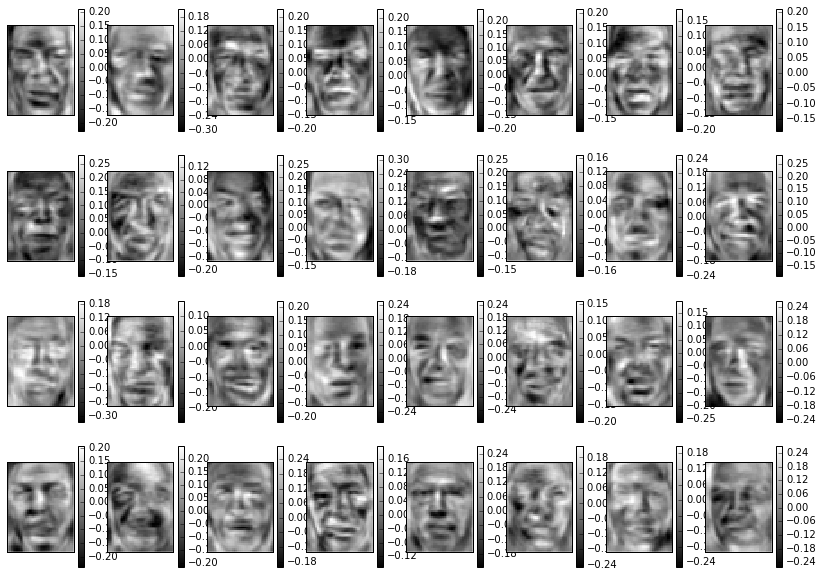

In [13]:
plot_faces(D.T, label=False)

$\textbf{Obtaining a sparse dico with normal constraints} $

In [14]:
X = dataset.data
X = scale(X,with_std=False) 
k = 150
A0 = normalize(np.random.randn(k, n_samples),norm="l2", axis = 1) #Our initialization should respect the constraints
D0 = np.random.randn(n_features, k)
n_iter = 100
l_l1 = 100

A, obj, D = solver(D0, A0, l_l1, n_iter=n_iter, method ="sparse dico", non_neg = False, verbose=False)

Lauching ISTA solver...
   it    |   obj    |   err   
...finished


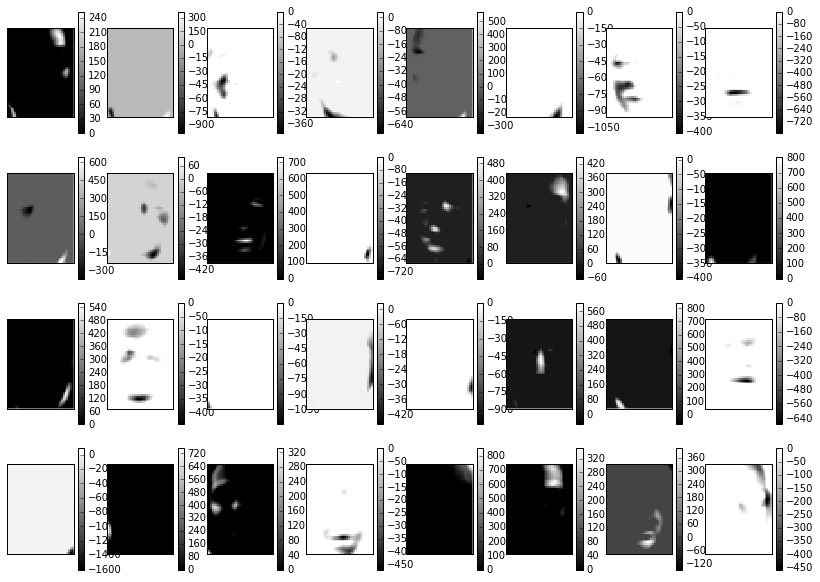

In [15]:
plot_faces(D.T, label=False)

Contrary to the first method, here we obtain a dictionary made of sparse atoms (i.e. the dico is sparse)

$\textbf{Obtaining a sparse dico with non-negativity constraints} $

In [16]:
X = dataset.data
#X = scale(X,with_std=True) no scaling for non-negativity constraints
k = 150
A0 = normalize(np.random.randn(k, n_samples),norm="l2", axis = 1) #Our initialization should respect the constraints
D0 = np.random.randn(n_features, k)
n_iter = 100
l_l1 = 100

A, obj, D = solver(D0, A0, l_l1, n_iter=n_iter, method ="sparse dico", non_neg = True, verbose=False)

Lauching ISTA solver...
   it    |   obj    |   err   
...finished


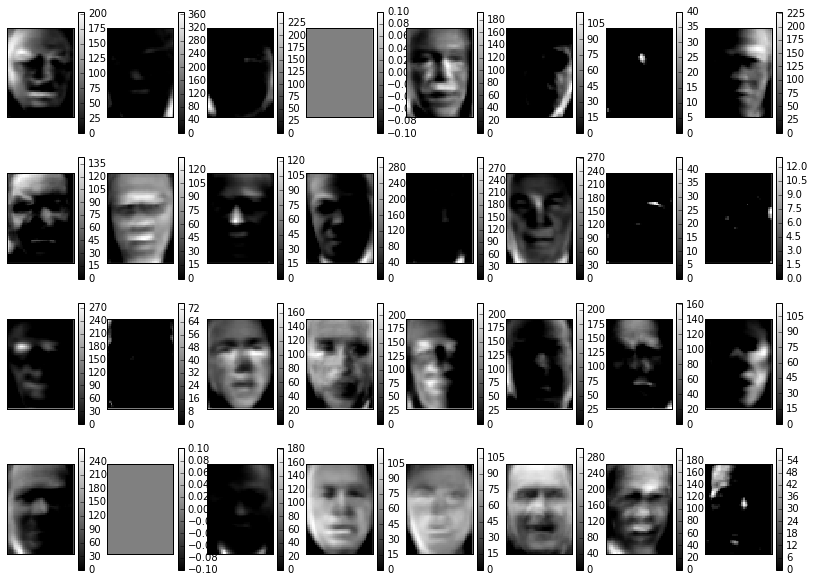

In [17]:
plot_faces(D.T, label=False)

Here we got, again, a sparse dictionary but, this time, with only positive coefficients.

$\textbf{Parameter optimization and methods benchmark}$

Two parameters remain to be fixed properly in the aim to maximize our ability to classify faces : k (the size of the dico) and $\lambda$ (our penalty). We will do a grid search for the 3 algorithms.

In [88]:
# Compute the cross-validation score of kNN on the new features obtained by PCA
X = dataset.data
X = scale(X,with_std=False) 
A0 = normalize(np.random.randn(k, n_samples),norm="l2", axis = 1) #Our initialization should respect the constraints
D0 = np.random.randn(n_features, k)
n_iter = 100

clf = KNeighborsClassifier(n_neighbors=1)

scores_dico = np.zeros((5,10))
n_components_range = np.arange(10, 200, 20) #I restrained the scale of the search because it's very time-consuming
lambdas = np.arange(10,110,20)
for i,l1 in enumerate(lambdas):
    for j,n_components in enumerate(n_components_range):
        A, obj, D = solver(D0, A0, l1, n_iter=n_iter, method ="sparse code", non_neg = False, verbose=False)
        # n_components is the rank used in the SVD when fitting the PCA
        X_pca = A[:n_components, :].T
        scores_dico[i,j] = cross_val_score(clf, X_pca, y, cv=2).mean()
    print "Line computed"
        


Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Line computed
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Lauching ISTA solver...
   it    |   obj    |   

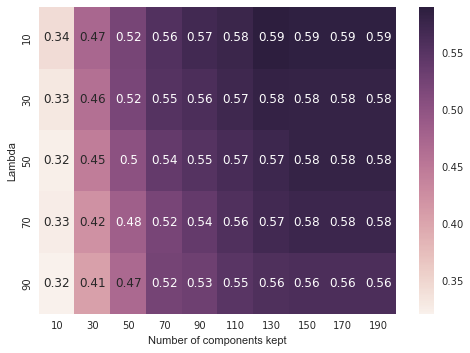

In [96]:
import seaborn as sb
f, ax = plt.subplots(1)
sb.heatmap(scores_dico,annot = True ,xticklabels=n_components_range,yticklabels=lambdas)
ax.set_xlabel("Number of components kept")
ax.set_ylabel("Lambda")

Because this process is very time consumming, I kept lambda fixed to a value around 20 and k around 130. Let's have a look at the X-validated errors.

In [21]:
X = dataset.data
X = scale(X,with_std=False) 

clf = KNeighborsClassifier(n_neighbors=1)
n_components = 130


#First solver
X = scale(X,with_std=False) 
A0 = np.random.randn(k, n_samples) 
D0 = normalize(np.random.randn(n_features, k), norm="l2", axis=1)

A, obj, D = solver(D0, A0, l_l1=20, n_iter=150, method ="sparse code", non_neg = False, verbose=False)
X_pca = A[:n_components, :].T
score = cross_val_score(clf, X_pca, y, cv=2).mean()
print "Score with sparse code : ",score

#Second solver
X = scale(X,with_std=False) 
A0 = normalize(np.random.randn(k, n_samples), norm="l2", axis=1) 
D0 = np.random.randn(n_features, k)

A, obj, D = solver(D0, A0, l_l1=20, n_iter=150, method ="sparse dico", non_neg = False, verbose=False)
X_pca = A[:n_components, :].T
score = cross_val_score(clf, X_pca, y, cv=2).mean()
print "Score with sparse dico : ",score

#Third solver
X = dataset.data
A0 = normalize(np.random.randn(k, n_samples), norm="l2", axis=1) 
D0 = np.random.randn(n_features, k)

A, obj, D = solver(D0, A0, l_l1=20, n_iter=150, method ="sparse dico", non_neg = True, verbose=False)
X_pca = A[:n_components, :].T
score = cross_val_score(clf, X_pca, y, cv=2).mean()
print "Score with sparse dico and non-negativity constraints : ",score


Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Score with sparse code :  0.576102157538
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Score with sparse dico :  0.635897398802
Lauching ISTA solver...
   it    |   obj    |   err   
...finished
Score with sparse dico and non-negativity constraints :  0.559064648978


Non negativity constraints doesn't seem very meaningful here...

## Question 5 : online dictionary learning

Here I will use Mairal's paper notation.

I implemented Mairal's online dictionary learning algorithm using the LARS solver proposed by sklearn.

In [71]:
def px():
    #This function will draw a line of X uniformly
    n = X.shape[0]    
    p = X.shape[1]
    selected_line = np.random.randint(low=0,high=n)
    x = X[selected_line,:]
    x = np.expand_dims(x,axis=1)
    return x


def dictionary_update(D,A,B,it=1):
    #This function is Mairal's "algorithm 2"
    #A belongs to R k*k
    #B belongs to R m*k
    #D belongs to R m*k (our dictionary)
    m = D.shape[0]    
    k = D.shape[1]
    D_up=D.copy()
    
    
    for iteration in range(it) :
        for j in range(k) :
            u_j = (1/A[j,j])*(B[:,j]-D_up.dot(A[:,j]))+D_up[:,j]
            D_up[:,j]=(1/max(1,np.linalg.norm(u_j)))*u_j
            
    return D_up
            
def online_dic_learning(l1,D,T):
    #X observation sample vector, belong to R m
    #l1 : lambda penalization parameter
    #D our current dictionary, belongs to R m*k
    #T number of iterations
    
    from sklearn.linear_model import LassoLars
    m = D.shape[0]    
    k = D.shape[1]
    
    solver = LassoLars(alpha=l1,fit_intercept=False,normalize=False)
    A = np.zeros((k,k),dtype=float)
    B = np.zeros((m,k),dtype=float)
    
    for iteration in range(T):
        #print "interation N° : ", iteration
        #Draw x_t with respect to p(x)
        x = px() 
        
        #Sparse coding: compute alpha using LARS
        solver.fit(D,x) 
        alpha = solver.coef_  
        alpha = np.expand_dims(alpha,axis=1)
        
        #Update the matrices with the previous solution according to Mairal paper's
        A = A + alpha.dot(alpha.T)  
        B = B + x.dot(alpha.T)
        
        #Update the dictionary 
        D = dictionary_update(D,A,B,it=2)
    
    return D

Let's test the algorithm !

In [78]:
X = dataset.data
X = scale(X,with_std=True) #We need to scale the input data to use Mairal's algorithm
n = X.shape[0]    
p = X.shape[1]
k = 50 #Fix the k parameter
D = np.random.randn(p,k)
l1 = 0.0001

#Center the data


D=online_dic_learning(l1,D,T=500)

C:\Users\Hugo\AppData\Roaming\Python\Python27\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.471e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
C:\Users\Hugo\AppData\Roaming\Python\Python27\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=1.471e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 3.332e-08
  ConvergenceWarning)
C:\Users\Hugo\AppData\Roaming\Python\Python27\site-packages\sklearn\linear_model\least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.470e-04, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.788e-08
  Conver

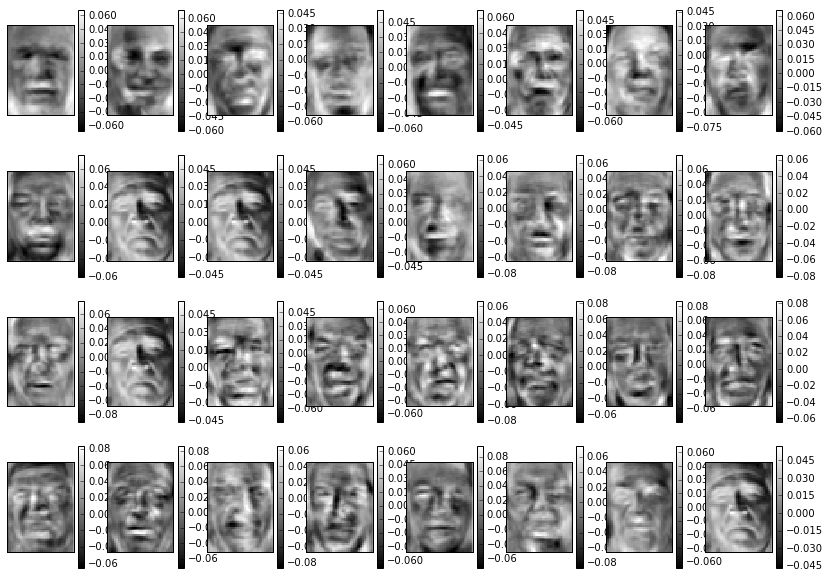

In [79]:
plot_faces(D.T,label=False)

Here, because the method is online, we don't get a $A$ matrix respecting the definition of question 1,2,3,4. Moreover the examples used for training are chosen randomly, thus it is difficult to compare the accuracy of the online method to the batch method. 

However, the methods seems to create a dictionary not far from the one we observed before, but a lot faster.

## Conclusion

In this project we implemented different dictionary learning (matrix factorization) algorithms. They showed good performances, in the context of face recognition, as a preprocessing step before running a machine learning algorithm on the data.

More specifically, on this particular dataset, we came to the following conclusions :
- Sparse dico learning seems to be more efficient than sparse coding
- Non negativity constraints doesn't improve the results

A cleaner hyper-optimization may have resulted in more accurate results.